In [1]:
# source source.me before launching jupyter
# export DWAVE_API_TOKEN=DEV-7dfad1c79ca4cac893a1541f6d04fbb3c2dced5c

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2
%env CUDA_LAUNCH_BLOCKING=1
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2
env: CUDA_LAUNCH_BLOCKING=1
Fri Sep 29 08:51:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 30%   34C    P8     6W / 250W |   2405MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[08:51:39.934] INFO   CaloQVAE                                          Willkommen!
[08:51:39.937] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/fast_scratch/QVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

2023-09-29 08:51:42,663 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[08:51:42.663] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [7]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/usr/local/lib/python3.8/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[08:51:48.459] INFO   data.dataManager                                  Loading Data


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_

[08:52:10.478] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc2499e0280>: 80000 events, 625 batches
[08:52:10.480] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc4172e8ee0>: 10000 events, 79 batches
[08:52:10.481] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc4172d0c70>: 10000 events, 79 batches
[08:52:15.147] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasCRBMCNNDCond
2023-09-29 08:52:15,154 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[08:52:15.154] INFO   dwave.cloud.client.base                           Using region m

Initializing NetworkV3
Initializing NetworkV3


In [8]:
dataMgr._config.data

{'data_type': 'atlas', '_layers': ['showers'], 'particle_type': 'electron-ds2', 'dataset': 'dataset2', 'frac_test_dataset': 0.1, 'frac_train_dataset': 0.8, 'particle': 'electron', 'scaled': False, 'scaler_path': '/fast_scratch/QVAE/data/atlas_dataset2and3_scaled/dataset_2_1_scaler.gz', 'scaler_amin': '/fast_scratch/QVAE/data/atlas_dataset2and3_scaled/dataset_2_1_amin.npy', 'atlas_input_photon1': '/fast_scratch/QVAE/data/atlas/photons1.hdf5', 'atlas_input_photonEn0': '/fast_scratch/QVAE/data/atlas/photons_samples_highStat_En_0.hdf5', 'atlas_input_photonEn1': '/fast_scratch/QVAE/data/atlas/photons_samples_highStat_En_1.hdf5', 'atlas_input_photonEn2': '/fast_scratch/QVAE/data/atlas/photons_samples_highStat_En_2.hdf5', 'atlas_input_photonEn3': '/fast_scratch/QVAE/data/atlas/photons_samples_highStat_En_3.hdf5', 'atlas_input_photonEn4': '/fast_scratch/QVAE/data/atlas/photons_samples_highStat_En_4.hdf5', 'atlas_input_photonEn5': '/fast_scratch/QVAE/data/atlas_scaled/photons_samples_highStat_E

In [9]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[08:52:26.055] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 6480])
[08:52:26.057] INFO   wandb                                             Watching
/usr/local/lib/python3.8/dist-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[08:52:28.697] INFO   engine.engineAtlas                                Setting up engine Atlas.
[08:52:28.698] INFO   engine.engineCaloV3                               Setting up engine Calo.
[08:52:28.699] INFO   engine.engine                                     Setting up default engine.


In [10]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_

[08:52:52.395] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc249a5a6d0>: 80000 events, 625 batches
[08:52:52.399] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc249a5a3a0>: 10000 events, 79 batches
[08:52:52.400] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc249a5a7f0>: 10000 events, 79 batches


In [11]:
###LOAD MODEL
import h5py

data = h5py.File('/fast_scratch/QVAE/data/atlas_dataset2and3/dataset_2_1.hdf5', 'r')

print(data['showers'][0].sum())
print(data['incident_energies'][0])
print(data.items())
print(data['showers'])

94183.4972091978
[118329.577806]
ItemsViewHDF5(<HDF5 file "dataset_2_1.hdf5" (mode r)>)
<HDF5 dataset "showers": shape (100000, 6480), type "<f8">


In [12]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [185]:


# Fully connected rbm
#run_path = "/home/sgonzalez/CaloQVAE/outputs/2023-09-25/10-00-01/wandb/run-20230925_100006-nw310wcn/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
#modelname = 'elated-breeze-1314'

# Denser Fully connected RBM
#run_path = "/home/sgonzalez/CaloQVAE/outputs/2023-09-26/10-32-04/wandb/run-20230926_103208-kvb2phz2/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
#modelname = 'neat-capybara-1318'

# Alpha=5, gamma=50 fully connected RBM
#run_path = "/home/sgonzalez/CaloQVAE/outputs/2023-09-27/14-21-02/wandb/run-20230927_142106-64dmkzez/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
#modelname = 'sage-resonance-1321'

# alpha=5, gamma=5, r=5e-5, fully connected RBM
#run_path = "/home/sgonzalez/CaloQVAE/outputs/2023-09-27/12-41-50/wandb/run-20230927_124154-249ic2o6/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
#modelname = 'faithful-energy-1320'

# alpha = 5.0, gamma = 25.0, r=5e-5, fully connected RBM
#run_path = "/home/sgonzalez/CaloQVAE/outputs/2023-09-28/13-03-20/wandb/run-20230928_130324-0x5tn7o3/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
#modelname = 'comic-capybara-1328'

# alpha = 5, gamma = 10, r=5e-5, fully connected RBM
#run_path = "/home/sgonzalez/CaloQVAE/outputs/2023-09-28/13-04-46/wandb/run-20230928_130450-16v0mju2/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
#modelname = 'elated-moon-1329'

run_path = "/home/sgonzalez/CaloQVAE/outputs/2023-09-27/12-41-50/wandb/run-20230927_124154-249ic2o6/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
modelname = 'faithful-energy-1320'
datascaled = 'scaled'
with open("/home/sgonzalez/CaloQVAE/outputs/2023-09-27/12-41-50/wandb/run-20230927_124154-249ic2o6/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled = False
    
    
    




arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
load_state(model, run_path, dev)
model.eval();

GumBoltAtlasCRBMCNNDCond
electron-ds2
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
Loading weights for module =  classifier
Loading weights for module =  sampler


In [186]:
xx = next(iter(train_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label
xx[0][0][0].sum()
#xx[1][0][0]

tensor(392836.8125)

torch.Size([128, 6480])


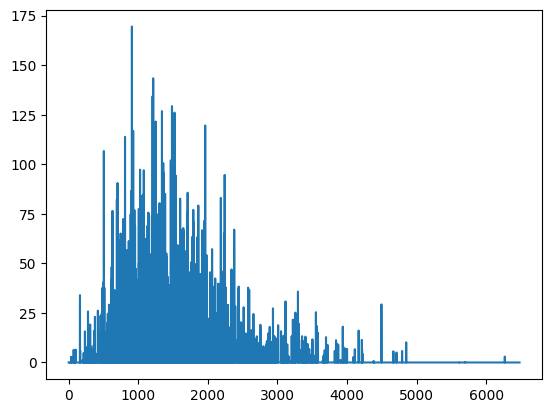

In [187]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[3,:])

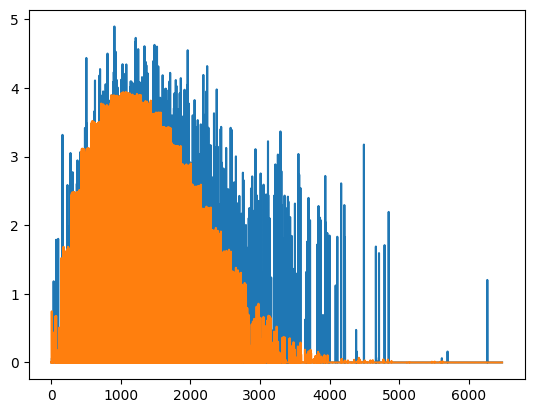

In [188]:
with torch.no_grad():
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    if reducedata:
        in_data = engine._reduce(in_data, true_energy, R=R)
    fwd_output = engine.model((in_data, true_energy), True)
idx = 3
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:])

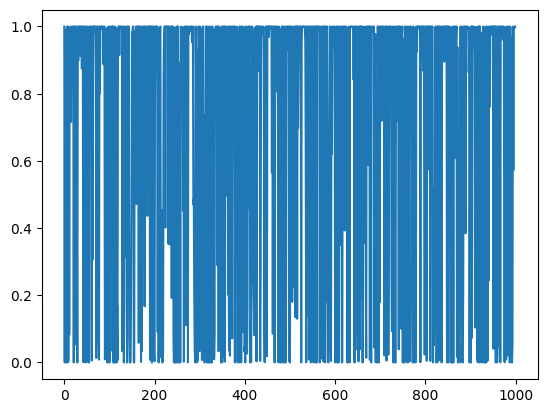

In [189]:
# enIn = torch.cat((in_data, true_energy), dim=1)
# beta, post_logits, post_samples = engine.model.encoder(enIn)
with torch.no_grad():
    # enIn = torch.cat((in_data, true_energy), dim=1)
    # beta, post_logits, post_samples = engine.model.encoder(enIn)
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
plt.plot(post_samples[0][0,:].detach().cpu().numpy())
post_samples = torch.cat(post_samples, 1)

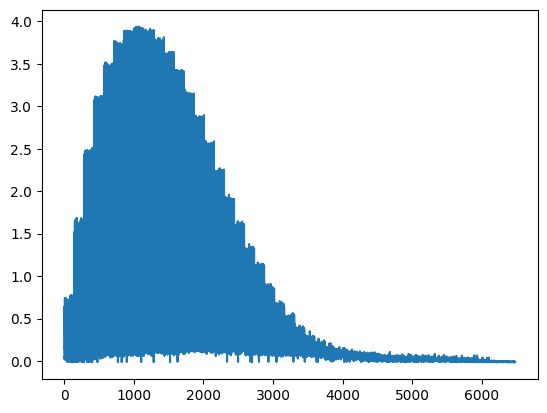

In [190]:
# post_samples = torch.cat([post_samples, true_energy], dim=1)
# output_hits, output_activations = engine.model.decoder(post_samples)
output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
plt.plot(output_activations[idx,:].detach().cpu().numpy())


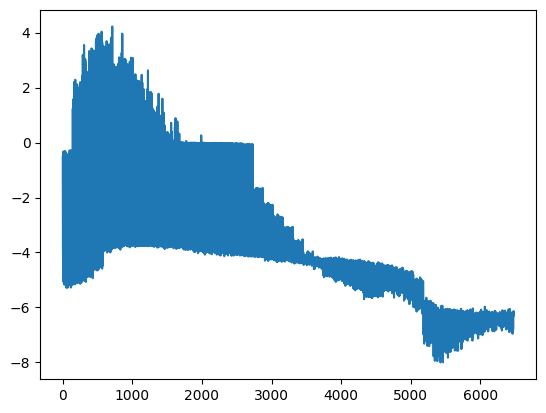

In [191]:
# self._hit_smoothing_dist_mod(output_hits, beta, is_training)
plt.plot(output_hits[1,:].detach().cpu().numpy())
beta = torch.tensor(5, dtype=torch.float, device=output_hits.device, requires_grad=False)

In [192]:
beta = torch.tensor(1, dtype=torch.float, device=output_hits.device, requires_grad=False)

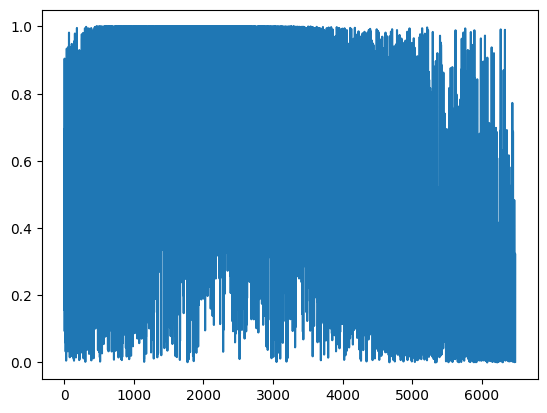

In [193]:
plt.plot(engine.model._hit_smoothing_dist_mod(output_hits, beta, True)[2,:].detach().cpu().numpy())

In [194]:
# for i in range(1,100):
#     print(533 % i, i, 533/i)

In [195]:
# engine.model._hit_smoothing_dist_mod(output_hits, torch.Tensor([5]), is_training=False)[idx,:].detach().cpu()
idx=5
# plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(23,16))
plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(41,13))

ValueError: cannot reshape array of size 6480 into shape (41,13)

In [196]:
# sample_energies
engine._config.engine.cl_lambda
reducedata
#true_energy.shape
# max(128*1024//engine._model.sampler.get_batch_size(), 1)
# true_energy[:100,:]
# engine._model.sampler._batch_size = 1024
#rbm_visible_samples, rbm_hidden_samples = engine._model.sampler.block_gibbs_sampling()

True

In [197]:
rbm_visible_samples, rbm_hidden_samples = engine._model.sampler.block_gibbs_sampling()
rbm_vis = rbm_visible_samples.detach()
rbm_hid = rbm_hidden_samples.detach()
rbm_vis.size()


torch.Size([128, 500])

In [198]:
# true_energy
# rbm_vis.device
engine._model.sampler

training: False
_parameters: OrderedDict()
_buffers: OrderedDict()
_non_persistent_buffers_set: set()
_backward_pre_hooks: OrderedDict()
_backward_hooks: OrderedDict()
_is_full_backward_hook: None
_forward_hooks: OrderedDict()
_forward_pre_hooks: OrderedDict()
_state_dict_hooks: OrderedDict()
_load_state_dict_pre_hooks: OrderedDict()
_load_state_dict_post_hooks: OrderedDict()
_modules: OrderedDict([('_RBM', RBM: n_vis=500, n_hid=500)])
n_gibbs_sampling_steps: 1000
_MCState: tensor([[1., 1., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 1., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 1., 1., 1.]])
_batch_size: 128

In [199]:
(torch.ones((rbm_vis.size(0), 1), device=rbm_vis.device).detach() * true_energy).shape

torch.Size([128, 1])

In [200]:
en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []
xgen_energies = []
true_energies = []

labelstarget_samples = []
labelsrecon_samples = []
for xx in val_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    
    '''
    new_data = torch.tensor([], device=dev)
    new_e = torch.tensor([], device=dev)
    
    base = 0
    diff = 400000
    for data, true_e in zip(in_data, true_energy):
            if true_e<(base+diff) and true_e>base:
                new_data = torch.cat((new_data, data.view(1, 6480)), dim=0)
                new_e = torch.cat((new_e, true_e.view(1,1)), dim=0)
    in_data = new_data
    true_energy = new_e
    
    if (in_data.size() == torch.Size([0])):
        continue
        
    num_samples = 500
    '''


    if reducedata:
        in_data = engine._reduce(in_data, true_energy, R=R)
    fwd_output = engine.model((in_data, true_energy), False)
    
    if reducedata: #That
        in_data = engine._reduceinv(in_data, true_energy, R=R)
        recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
        engine._model.sampler._batch_size = true_energy.shape[0]
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy) #engine._model.generate_samples(num_samples=num_samples, true_energy=base+ (diff*torch.rand((num_samples, 1), device=dev))) #
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
    elif scaled:
        in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
        recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
        engine._model.sampler._batch_size = num_samples#true_energy.shape[0]
        # try:
        sample_energies, sample_data = engine._model.generate_samples(num_samples=num_samples, true_energy=base+ (diff*torch.rand((num_samples, 1), device=dev)))#engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
        # except:
            # pass
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
        sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))

    # xrecon_samples.append( torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy())) )
    if engine._config.engine.cl_lambda:
        labelsrecon_samples.append(fwd_output.labels.detach().cpu())
        labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )
    
        en_labels.append(true_energy.detach().cpu())
    
    xtarget_samples.append(in_data.detach().cpu())
    xrecon_samples.append( recon_data.detach().cpu())
    xgen_samples.append( sample_data.detach().cpu())
    xgen_energies.append( sample_energies.detach().cpu())
    true_energies.append(true_energy.detach().cpu())
    
    # xtarget_samples.append( torch.tensor(engine._data_mgr.inv_transform(xx[0][0].detach().cpu().numpy())) )
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
xgen_energies = torch.cat(xgen_energies, dim=0)
true_energies = torch.cat(true_energies, dim=0)

if engine._config.engine.cl_lambda:
    labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
    labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
    en_labels = torch.cat(en_labels, dim=0)

    lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
    l = torch.argmax(labelstarget_samples, dim=1).numpy()


In [201]:
(xgen_samples.sum(dim=0) == 0).sum()
#xgen_samples.sum(dim=1).size()

tensor(549)

gen
0


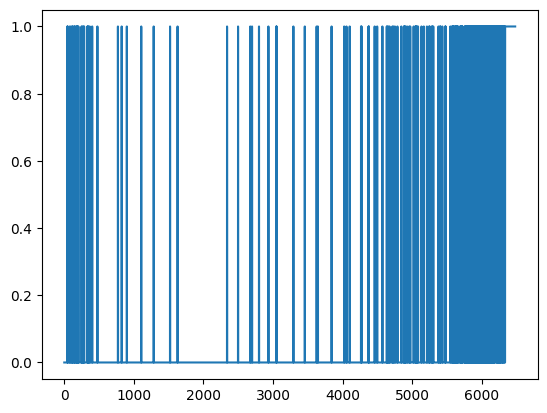

In [202]:

# # (xrecon_samples.sum(dim=1) == 0)[0].item()
# for i, iszero in enumerate(xrecon_samples.sum(dim=0) == 0):
#     if iszero:
#         print(i)
# print("gen")        
# for i, iszero in enumerate(xgen_samples.sum(dim=0) == 0):
#     if iszero:
#         print(i)

l1 = 0
for i, iszero in enumerate(xtarget_samples.sum(dim=0) == 0):
    if iszero:
        # print(i)
        l1 +=1

l2 = []
for i, iszero in enumerate(xrecon_samples.sum(dim=0) == 0):
    if iszero:
        # print(i)
        # l2 +=1
        l2.append(1)
    else:
        l2.append(0)
print("gen") 
l3 = []
for i, iszero in enumerate(xgen_samples.sum(dim=0) == 0):
    if iszero:
        # l3+=1
        l3.append(1)
    else:
        l3.append(0)
    
print(l1)
plt.plot(l2)
# plt.plot(l3)
plt.show()

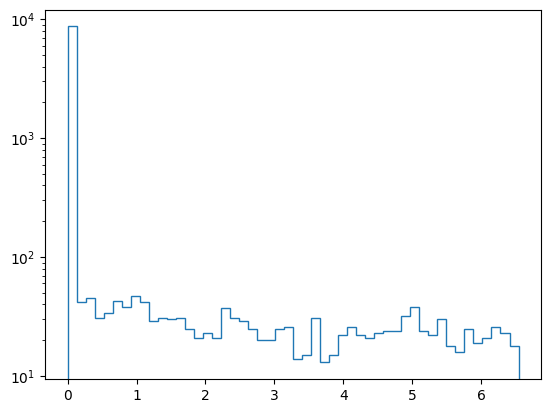

In [203]:
idx = 1
plt.hist(xrecon_samples[:,idx], bins=50, log=True, histtype='step')
plt.show()

In [204]:
xtarget_samples.shape[1]

6480

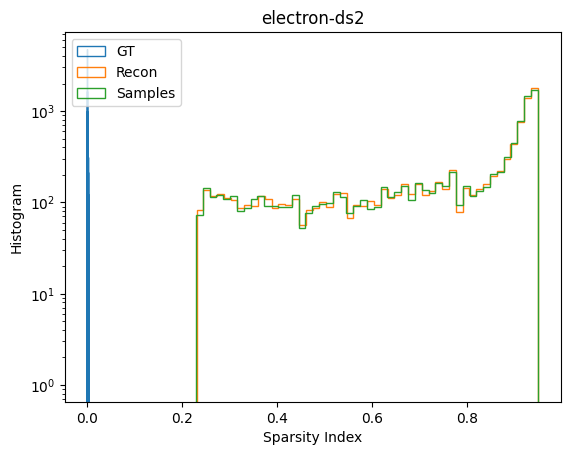

In [205]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=50, log=True, histtype='step')
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=50, log=True, histtype='step')
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=50, log=True, histtype='step')
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples"])
plt.title(f'{part}')
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [206]:
np.exp(8)

2980.9579870417283

Layer  0 144  voxels


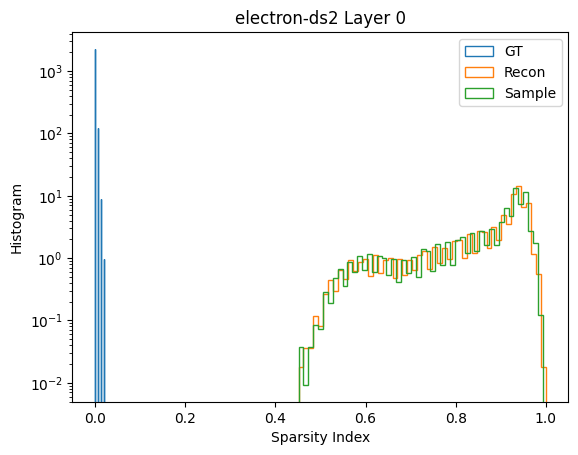

Layer  1 144  voxels


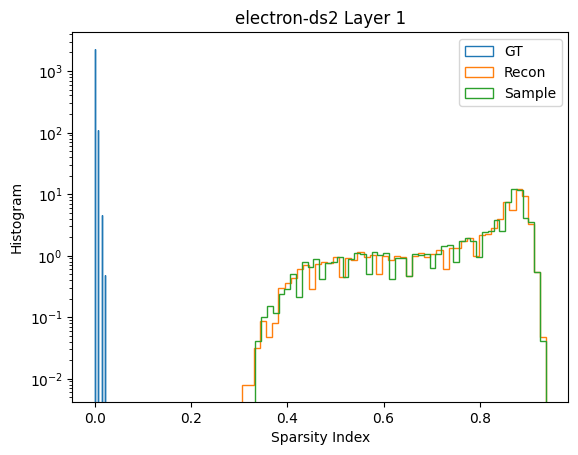

Layer  2 144  voxels


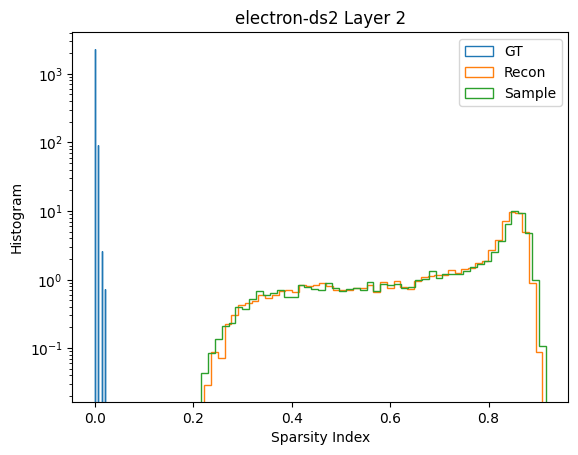

Layer  3 144  voxels


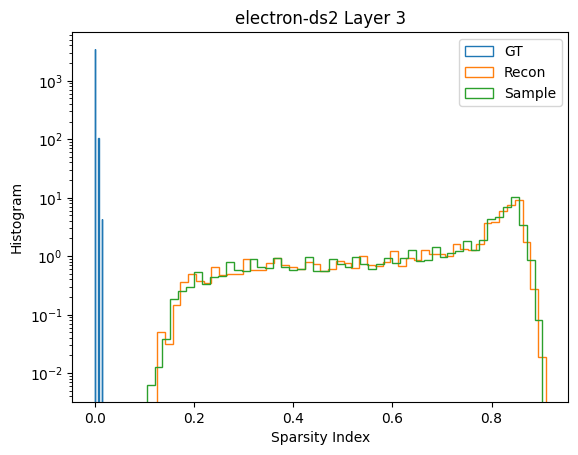

In [207]:
idxPrev = 0
# for i,idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
for i, idx in enumerate([16*9*i for i in range(1,5)]):
# for i,idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=50, log=True, histtype='step', density=True)
    plt.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=50, log=True, histtype='step', density=True)
    plt.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=50, log=True, histtype='step', density=True)
    plt.xlabel("Sparsity Index")
    plt.ylabel("Histogram")
    plt.legend(["GT", "Recon", "Sample"])
    plt.title(f'{part} Layer {i}')
    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

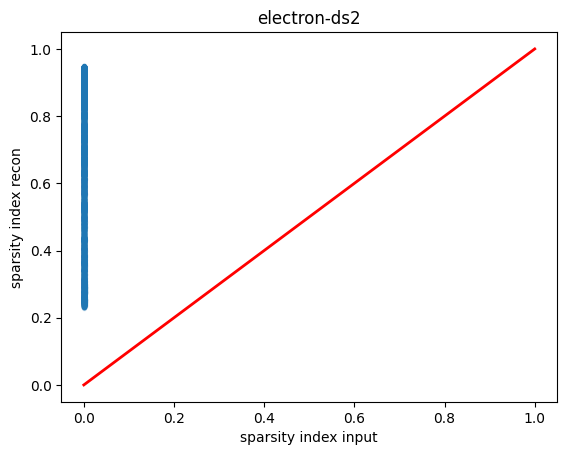

In [208]:
plt.scatter(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), ((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(),  marker='.', alpha=.2)
plt.plot([0,1],[0,1], c='red', lw=2)
plt.xlabel('sparsity index input')
plt.ylabel('sparsity index recon')
plt.title(f'{part}')
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

Layer  0 8  voxels


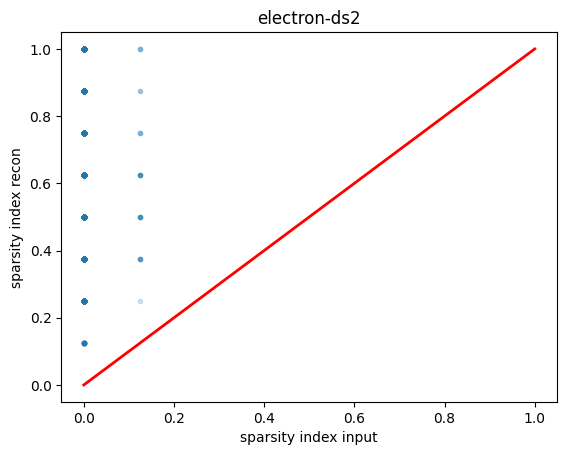

Layer  1 100  voxels


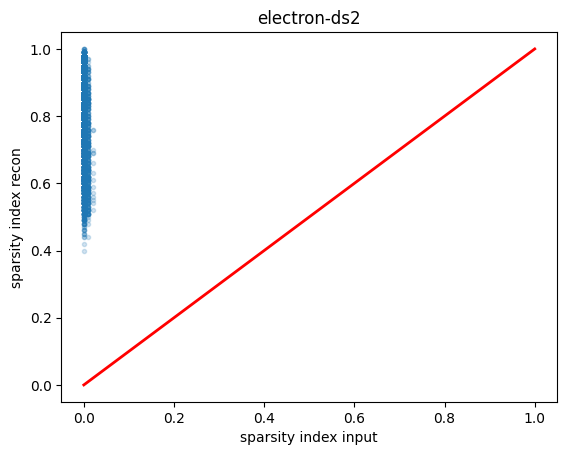

Layer  2 100  voxels


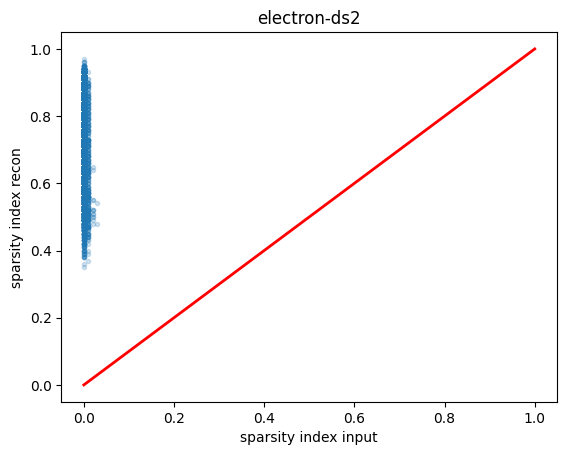

Layer  3 5  voxels


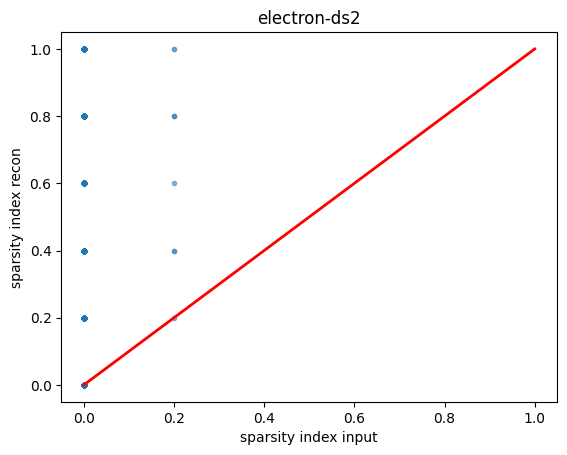

Layer  4 150  voxels


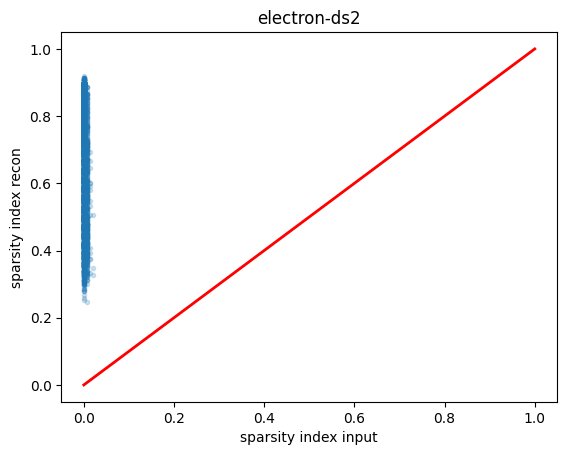

Layer  5 160  voxels


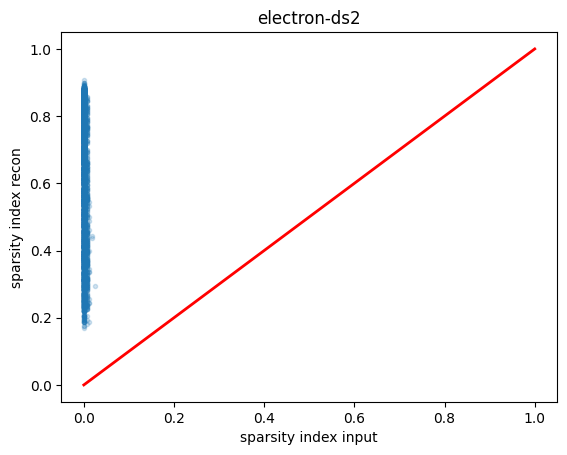

Layer  6 10  voxels


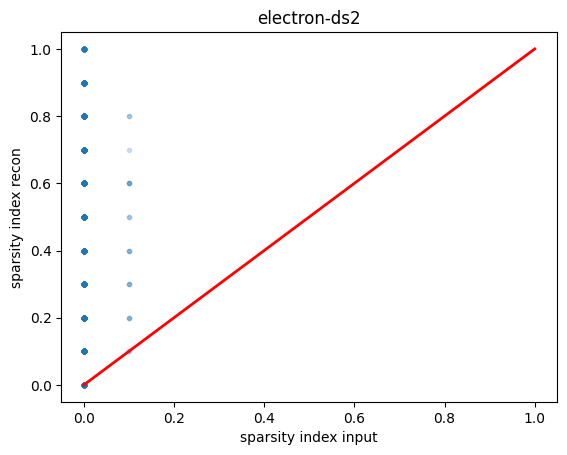

In [209]:
idxPrev = 0
for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.scatter(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), ((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), marker='.', alpha=.2)
    plt.plot([0,1],[0,1], c='red', lw=2)
    plt.xlabel('sparsity index input')
    plt.ylabel('sparsity index recon')
    plt.title(f'{part}')
    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

In [210]:
# xihat_samples.shape
np.unique(HLF_1_photons.bin_edges)

array([  0,   8, 168, 358, 363, 368])

In [211]:
bins = np.arange(0, 10 + 1)
bins

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

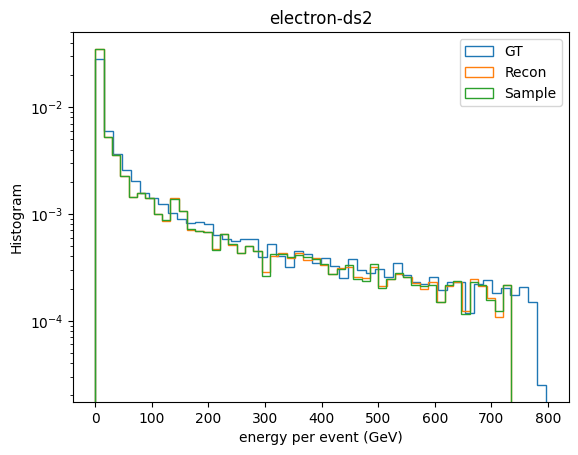

tensor(735092.6250)

In [212]:
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step', density=True)
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step', density=True)
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step', density=True)
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
plt.xlabel("energy per event (GeV)")

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample"])
plt.title(f'{part}')
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
xtarget_samples.size()
max(xgen_samples.sum(dim=1))

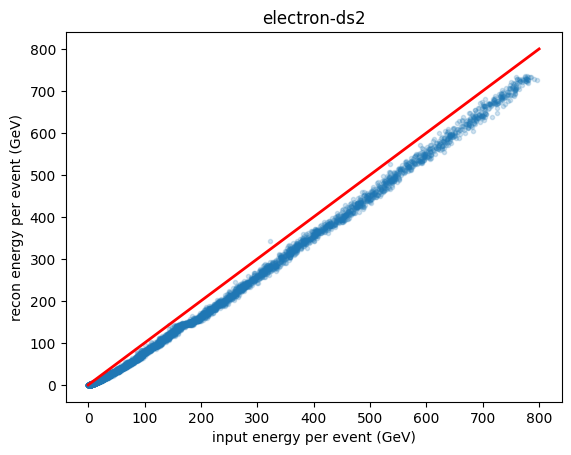

In [213]:
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.2)
plt.plot([0,800],[0,800], c='red', lw=2)

# sample_data_test = (sam.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),0)
# plt.hist(np.log(sample_data_test.sum(dim=1).numpy() + 1e-10), bins=10, density=False, alpha=0.7)
plt.xlabel("input energy per event (GeV)")
plt.ylabel("recon energy per event (GeV)")
plt.title(f'{part}')
# plt.yscale('log')
# plt.xscale('log')
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

# np.power(2,13)

In [47]:
# plt.hist(xitarget_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.hist(xirecon_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.hist(xihat_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.xlabel("ξ per event")
# plt.ylabel("PDF")
# plt.legend(["GT", "Recon", "Sample"])
# plt.title("Pions")
# plt.show()
# [16*9*i for i in range(1,46)]

Layer  0 1440  voxels


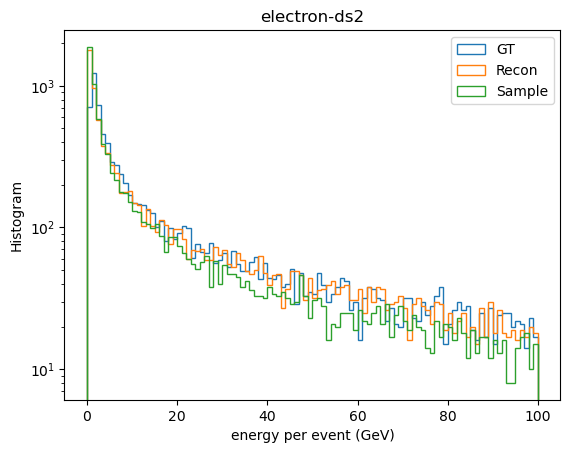

Layer  1 144  voxels


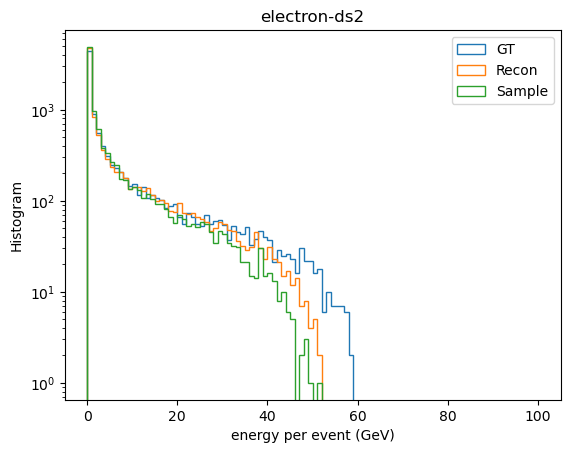

Layer  2 144  voxels


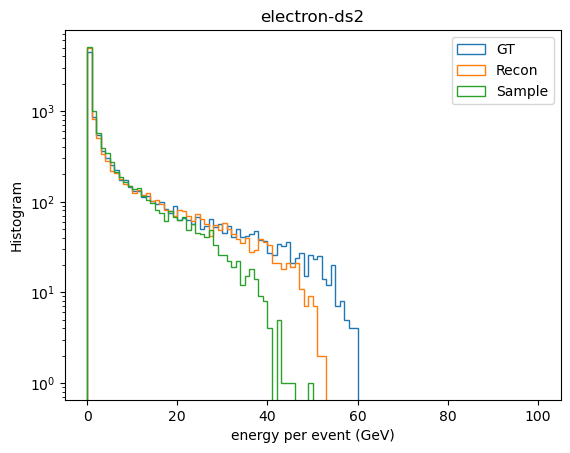

Layer  3 144  voxels


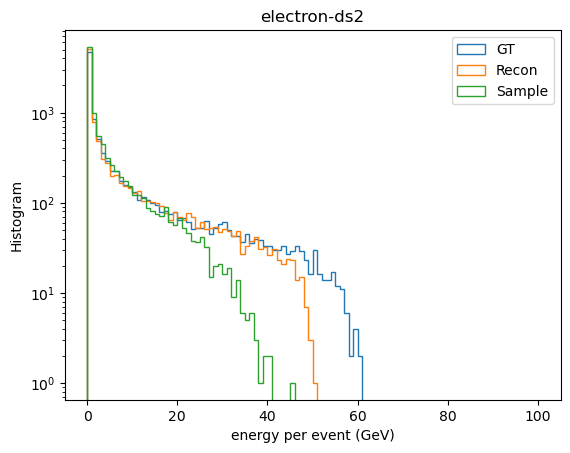

Layer  4 144  voxels


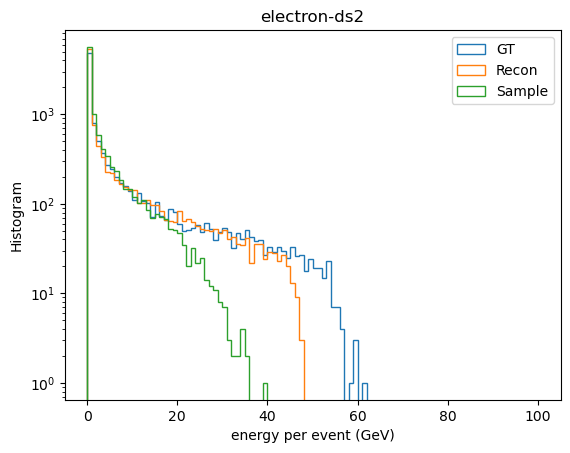

Layer  5 144  voxels


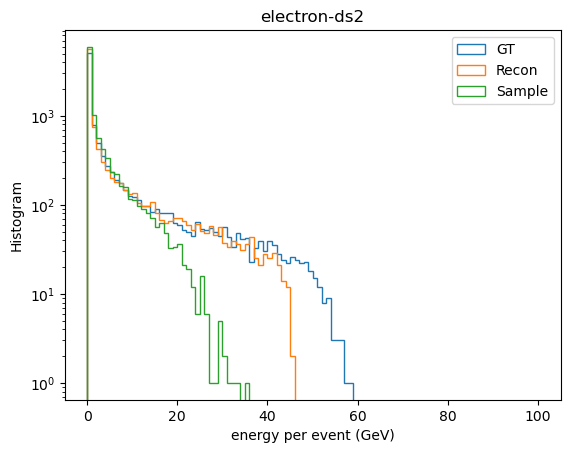

Layer  6 144  voxels


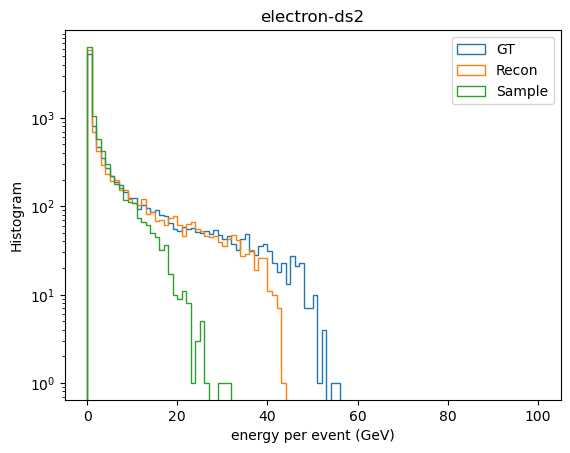

Layer  7 144  voxels


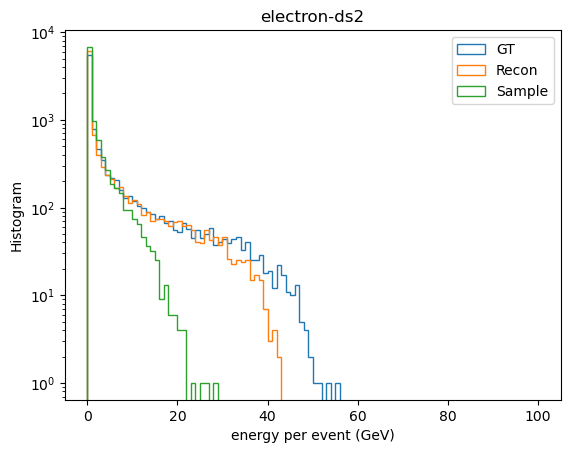

Layer  8 144  voxels


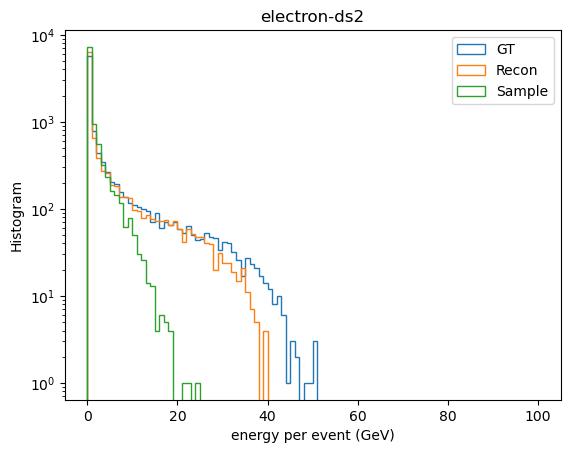

Layer  9 144  voxels


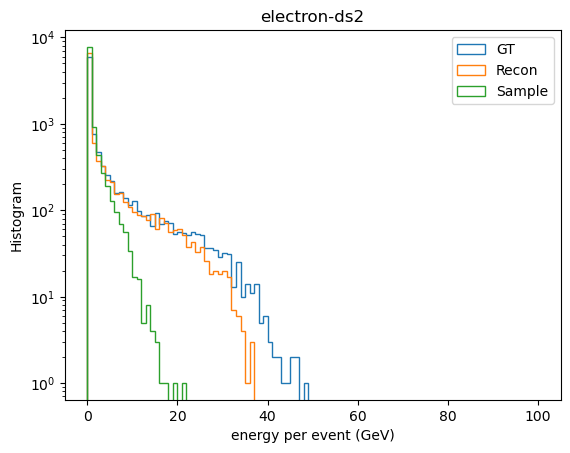

In [112]:
idxPrev = 0
# for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
for i, idx in enumerate([16*9*i for i in range(10,20)]):
# for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
    plt.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
    plt.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
    plt.xlabel("energy per event (GeV)")
    plt.ylabel("Histogram")
    plt.legend(["GT", "Recon", "Sample"])
    plt.title(f'{part}')
    # # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

Layer  0 1440  voxels


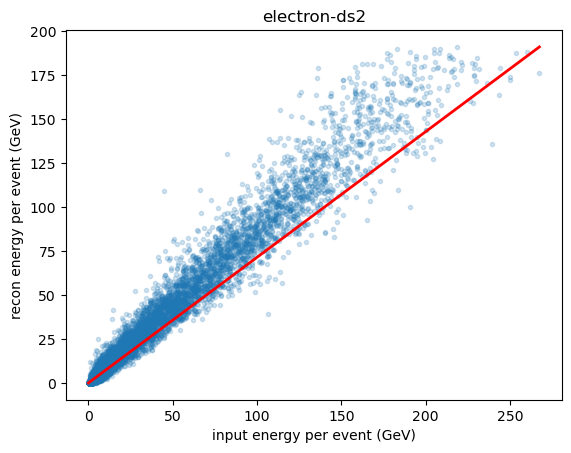

Layer  1 144  voxels


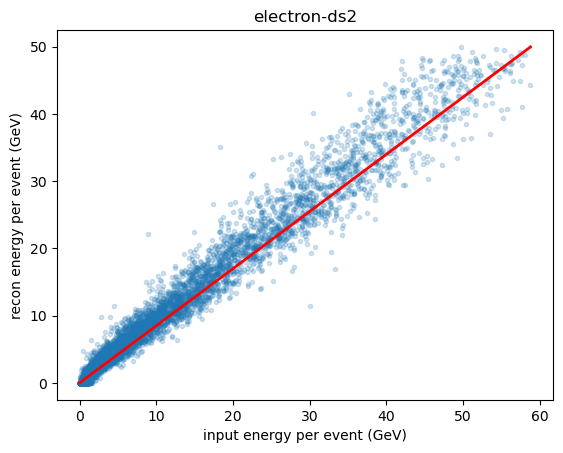

Layer  2 144  voxels


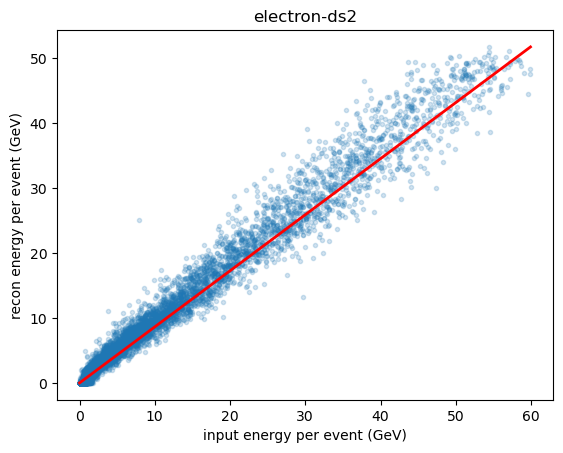

Layer  3 144  voxels


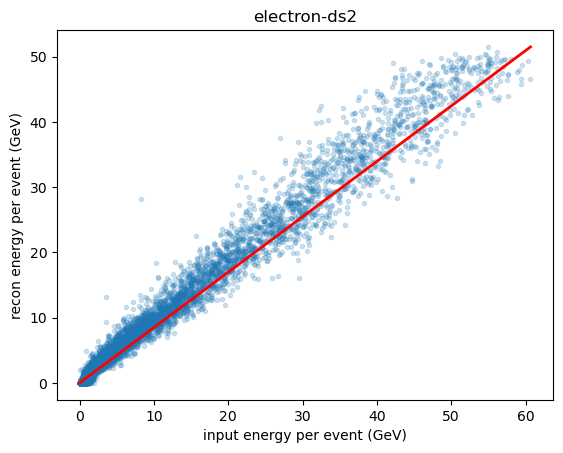

Layer  4 144  voxels


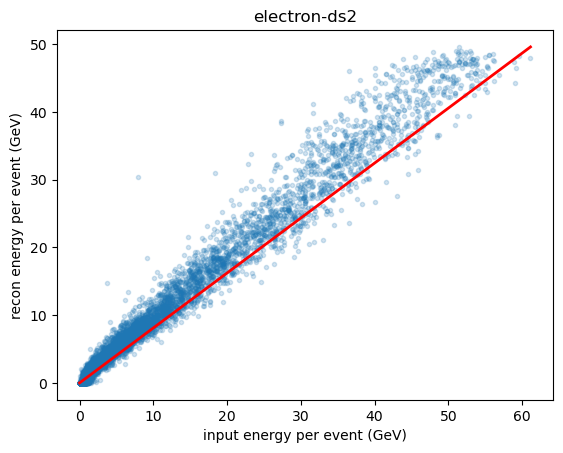

Layer  5 144  voxels


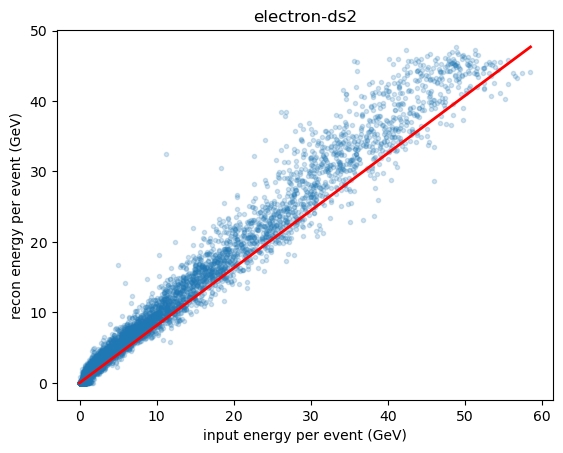

Layer  6 144  voxels


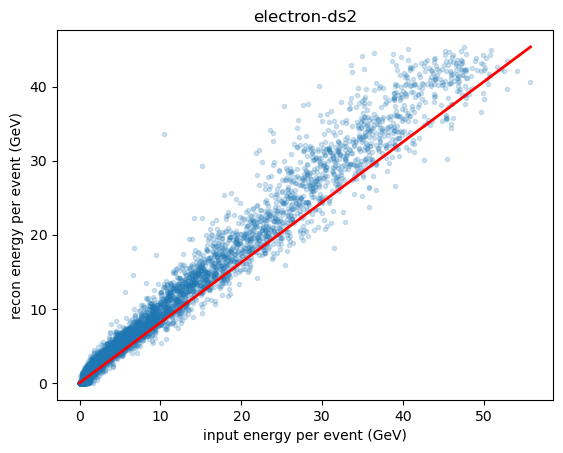

Layer  7 144  voxels


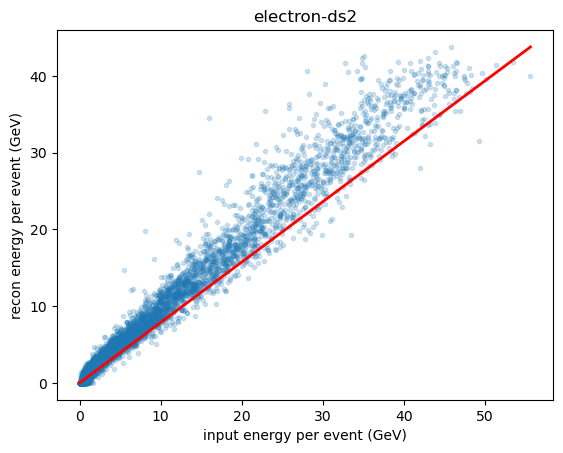

Layer  8 144  voxels


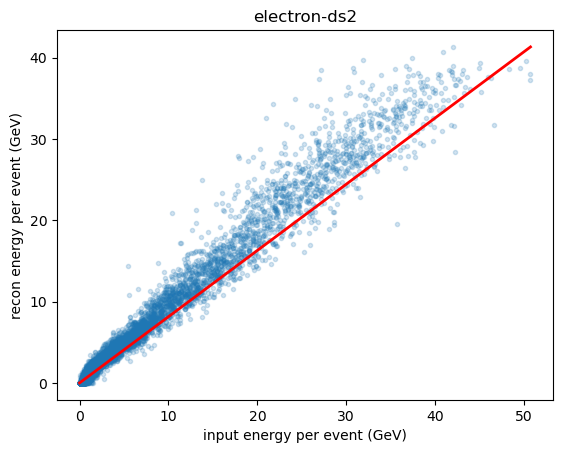

Layer  9 144  voxels


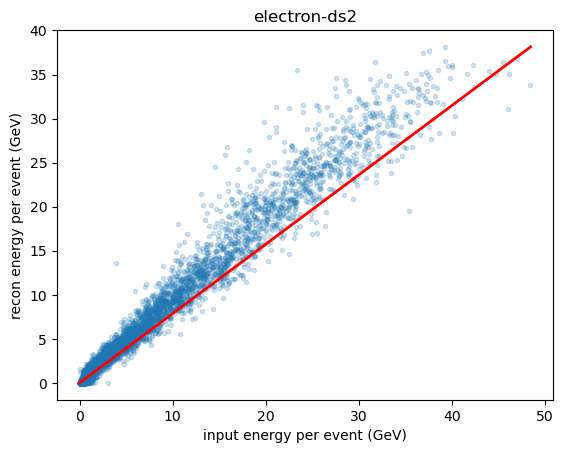

In [167]:
idxPrev = 0
# for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
for i, idx in enumerate([16*9*i for i in range(10,20)]):
# for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.scatter(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, marker='.', alpha=.2)
    plt.plot([0,xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000],[0,xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000], c='red', lw=2)
    
    plt.xlabel("input energy per event (GeV)")
    plt.ylabel("recon energy per event (GeV)")
    plt.title(f'{part}')
    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

In [151]:
np.unique(HLF_1_pions.bin_edges)

array([  0,   8, 108, 208, 213, 363, 523, 533])

In [69]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

In [70]:
if reducedata:
    in_data = engine._reduce(in_data, true_energy, R=R)
fwd_output = engine.model((in_data, true_energy), False)
if reducedata:
    in_data = engine._reduceinv(in_data, true_energy, R=R)
    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
    sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
elif scaled:
    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
    engine._model.sampler._batch_size = true_energy.shape[0]
    # try:
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    # except:
        # pass
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))

In [96]:
HLF_1_pions.relevantLayers = [1,2,3,4,5,6,7]

In [41]:
HLF_1_electron.relevantLayers = [5,10,15,30,35]

In [31]:
# (((in_data[:,0:108] - recon_data[:,0:108])/(in_data[:,0:108]))**2).sum(dim=1).argsort()[:20]
(((in_data - recon_data)/in_data)**2).sum(dim=1).argsort()[:20]

tensor([688, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
        686, 687, 672, 689, 690, 691])

In [75]:
# HLF_1_photons.DrawSingleShower(in_data[0,:].detach().cpu().numpy(), filename=None)
idx=691
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), 
                             # filename=f'/home/javier/Projects/CaloQVAE/figs/target_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), 
                                filename=f'/home/javier/Projects/CaloQVAE/figs/target_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
# HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), 
#                                 filename=None)


In [76]:
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), 
#                              filename=f'/home/javier/Projects/CaloQVAE/figs/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), 
                                filename=f'/home/javier/Projects/CaloQVAE/figs/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
# HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), 
#                                 filename=None)


In [77]:
# HLF_1_pions.DrawSingleShower(sample_data[1,:].detach().cpu().numpy(), 
#                              filename=f'/home/javier/Projects/CaloQVAE/figs/sample_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(sample_data[1,:].detach().cpu().numpy(), 
                             filename=f'/home/javier/Projects/CaloQVAE/figs/sample_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
# HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), 
#                              filename=None)

In [ ]:
# Gen synth data

In [51]:
import h5py

In [52]:
ef = h5py.File('/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/dataset_2_1.hdf5', 'r')

In [54]:
ef["showers"]

<HDF5 dataset "showers": shape (100000, 6480), type "<f8">

(array([684.,  89.,  70.,  45.,  40.,  29.,  21.,  19.,  14.,  13.]),
 array([  1.01109469, 100.08539581, 199.15969849, 298.23397827,
        397.30828857, 496.38259888, 595.45690918, 694.53118896,
        793.60546875, 892.67980957, 991.75408936]),
 <BarContainer object of 10 artists>)

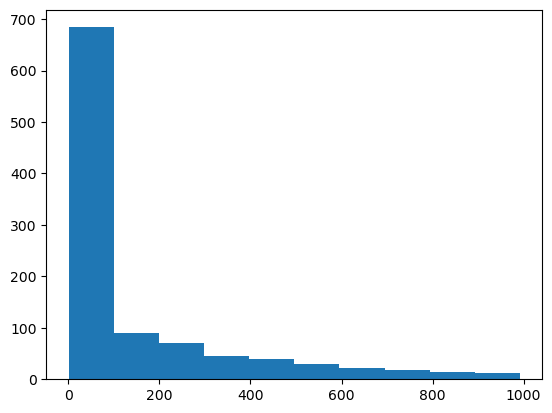

In [57]:
plt.hist(true_energy.detach().cpu().numpy()/1000)

In [62]:
in_data.sum(dim=1)

tensor([  2251.5442,   2548.4956, 197991.8125,  ...,   1088.8044,
         83722.3125,  28762.7969])

In [63]:
true_energy

tensor([[  2128.1135],
        [  3865.5706],
        [256267.9375],
        ...,
        [  1324.8855],
        [110361.2812],
        [ 35360.6562]], device='cuda:0')